In [1]:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
import argparse
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch.backends.cudnn as cudnn
import tensorflow as tf

ROOT_YOLOV5 = Path('./yolov5')
ROOT_EFFICIENTNETV2 = Path('automl/efficientnetv2')

if str(ROOT_YOLOV5) not in sys.path and str(ROOT_EFFICIENTNETV2) not in sys.path:
    sys.path.insert(0, str(ROOT_YOLOV5))
else:
    sys.path[0] = str(ROOT_YOLOV5)
    
from models.common import DetectMultiBackend
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr, \
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync

%matplotlib inline

In [2]:
os.getcwd()

'/Users/f0z01ld/Work/object-recognition-yolov5-efficientnetv2'

In [3]:
sys.modules['utils']

<module 'utils' from '/Users/f0z01ld/Work/object-recognition-yolov5-efficientnetv2/yolov5/utils/__init__.py'>

In [4]:
@torch.no_grad()
def run(
        # weights=ROOT / 'yolov5s.pt',  # model.pt path(s) 
        weights        = 'weights/yolov5/yolov5s.pt',
        source         = ROOT_YOLOV5 / 'data/images',  # file/dir/URL/glob, 0 for webcam, datasets/SKU110K_fixed/images/test
        data           = ROOT_YOLOV5 / 'data/coco128.yaml',  # dataset.yaml path
        imgsz          = [640, 640],  # inference size (height, width)
        # conf_thres     = 0.25,  # confidence threshold
        conf_thres     = 0.1,  # confidence threshold    
        iou_thres      = 0.45,  # NMS IOU threshold
        max_det        = 1000,  # maximum detections per image
        device         = '',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img       = True,  # show results
        save_txt       = True,  # save results to *.txt
        save_conf      = True,  # save confidences in --save-txt labels
        save_crop      = True,  # save cropped prediction boxes
        nosave         = False,  # do not save images/videos
        classes        = None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms   = False,  # class-agnostic NMS
        augment        = False,  # augmented inference
        visualize      = False,  # visualize features
        update         = False,  # update all models
        project        = 'runs/detect',  # save results to project/name
        name           = 'exp',  # save results to project/name
        # exist_ok=False,  # existing project/name ok, do not increment
        exist_ok       = True,
        line_thickness = 3,  # bounding box thickness (pixels)
        hide_labels    = False,  # hide labels
        hide_conf      = False,  # hide confidences
        half           = False,  # use FP16 half-precision inference
        dnn            = False,  # use OpenCV DNN for ONNX inference
    ):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
    
    bs = 1  # batch_size
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
    dt, seen = [0.0, 0.0, 0.0], 0
    for path, im, im0s, vid_cap, s in dataset:
        t1 = time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
        pred = model(im, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2

        # NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        
        dt[2] += time_sync() - t3

        # Second-stage classifier (optional)
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                                
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))
                        if save_crop:
                            save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}_{names[c]}.jpg', BGR=True)
            
                    # print(xyxy, imc.shape)
                    x1, y1, x2, y2 = xyxy
                    x1 = int(x1)
                    y1 = int(y1)
                    x2 = int(x2)
                    y2 = int(y2)
                    im0_crop = im0[y1:y2, x1:x2, :]
                    
                    fig = plt.figure(facecolor='w', edgecolor='k', frameon=False)
                    ax = fig.add_subplot(111)
                    plt.imshow(im0_crop)
                    _ = ax.set_aspect('equal')
                    ax.set_axis_off()
                    plt.show()
                    
                    return im0_crop
            
            # Stream results
            im0 = annotator.result()
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)

        # Print time (inference-only)
        LOGGER.info(f'{s}Done. ({t3 - t2:.3f}s)')
        break
    
    # Print results
    t = tuple(x / seen * 1E3 for x in dt)  # speeds per image
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(weights)  # update model (to fix SourceChangeWarning)   

YOLOv5 🚀 v6.1-32-gc13d4ce torch 1.8.0 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients


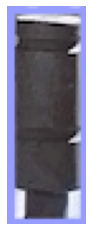

In [5]:
check_requirements(exclude=('tensorboard', 'thop'))
im0_crop = run()

In [6]:
if str(ROOT_EFFICIENTNETV2) not in sys.path:
    sys.path[0] = str(ROOT_EFFICIENTNETV2)

In [7]:
del sys.modules['utils']
del IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
del (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
del Annotator, colors, save_one_box
# del select_device, time_sync

In [8]:
import utils
sys.modules['utils']

<module 'utils' from '/Users/f0z01ld/Work/object-recognition-yolov5-efficientnetv2/automl/efficientnetv2/utils.py'>

In [16]:
from pathlib import Path
import sys
import os
import tensorflow as tf

ROOT_EFFICIENTNETV2 = Path('automl/efficientnetv2')
if str(ROOT_EFFICIENTNETV2) not in sys.path:
    # sys.path.append(str(ROOT_EFFICIENTNETV2))  # add ROOT to PATH
    sys.path.insert(0, str(ROOT_EFFICIENTNETV2))
ROOT_EFFICIENTNETV2 = Path(os.path.relpath(ROOT_EFFICIENTNETV2, Path.cwd()))  # relative

MODEL = 'efficientnetv2-b0'
CHKPTS_DIR  = Path('chkpts')
LABELS_PATH = Path('labels/labels_map.txt')

MODELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{MODEL}.tgz'
LABELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt'

# Build model
import effnetv2_model
# tf.keras.backend.clear_session()
model = effnetv2_model.EffNetV2Model(model_name=MODEL)

In [10]:
# !mkdir -p chkpts images labels

In [11]:
# Download model
# !wget $MODELS_URL -P $CHKPTS_DIR
# !tar -xvf {CHKPTS_DIR}/{MODEL}.tgz -C {CHKPTS_DIR}

# Download label map file
# !wget $LABELS_URL -O $LABELS_PATH

In [12]:
if tf.io.gfile.isdir( CHKPTS_DIR / MODEL ):
    chkpts_path = tf.train.latest_checkpoint(CHKPTS_DIR / MODEL)
chkpts_path

'chkpts/efficientnetv2-b0/model'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


top 1 (  2.3%):  home theater, home theatre 
top 2 (  1.5%):  library 
top 3 (  1.0%):  turnstile 
top 4 (  0.9%):  lipstick, lip rouge 
top 5 (  0.7%):  carpenter's kit, tool kit 


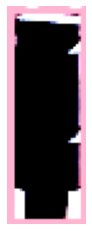

In [24]:
# Build model
from absl import logging
logging.set_verbosity(logging.ERROR)
tf.keras.backend.clear_session()
model = effnetv2_model.EffNetV2Model(model_name=MODEL)
_ = model(tf.ones([1, 224, 224, 3]), training=False)
_ = model.load_weights(chkpts_path)
cfg = model.cfg

# Pre-process image
mean_rgb = [0.485 * 255, 0.456 * 255, 0.406 * 255]
stddev_rgb = [0.229 * 255, 0.224 * 255, 0.225 * 255]
img_opencv = cv2.cvtColor(im0_crop.copy(), cv2.COLOR_BGR2RGB)
img_opencv = img_opencv - mean_rgb
img_opencv = img_opencv / stddev_rgb
img_opencv = np.expand_dims(img_opencv.astype(float), axis=0)
logits = model(img_opencv, False)

# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[::-1][:5].numpy()
import ast
classes = ast.literal_eval(open(LABELS_PATH, "r").read())
for i, id in enumerate(idx):
    print(f'top {i+1} ({pred[0][id]*100:5.1f}%):  {classes[id]} ')

fig = plt.figure(facecolor='w', edgecolor='k', frameon=False)
ax = fig.add_subplot(111)
plt.imshow(img_opencv[0])
_ = ax.set_aspect('equal')
ax.set_axis_off()
# plt.show()